In [ ]:
!pip install langchain_community sentence-transformers ctransformers pypdf faiss-gpu huggingface_hub matplotlib llama-cpp-python langchain


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

DATA_PATH = '/content/data'
DB_FAISS_PATH = 'vectorstore/db_faiss'

# Create vector database
def create_vector_db():
    loader = DirectoryLoader(DATA_PATH,
                             glob='*.pdf',
                             loader_cls=PyPDFLoader)

    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                                   chunk_overlap=50)
    texts = text_splitter.split_documents(documents)

    embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2',
                                       model_kwargs={'device':'cpu'})

    db = FAISS.from_documents(texts, embeddings)
    db.save_local(DB_FAISS_PATH)

if __name__ == "__main__":
    create_vector_db()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! model_type is not default parameter.
                model_type was transferred to model_kwargs.
                Please confirm that model_type is what you intended.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! max_new_tokens is not default parameter.
                max_new_tokens was transferred to model_kwargs.
                Please confirm that max_new_tokens is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /content/drive/MyDrive/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str     

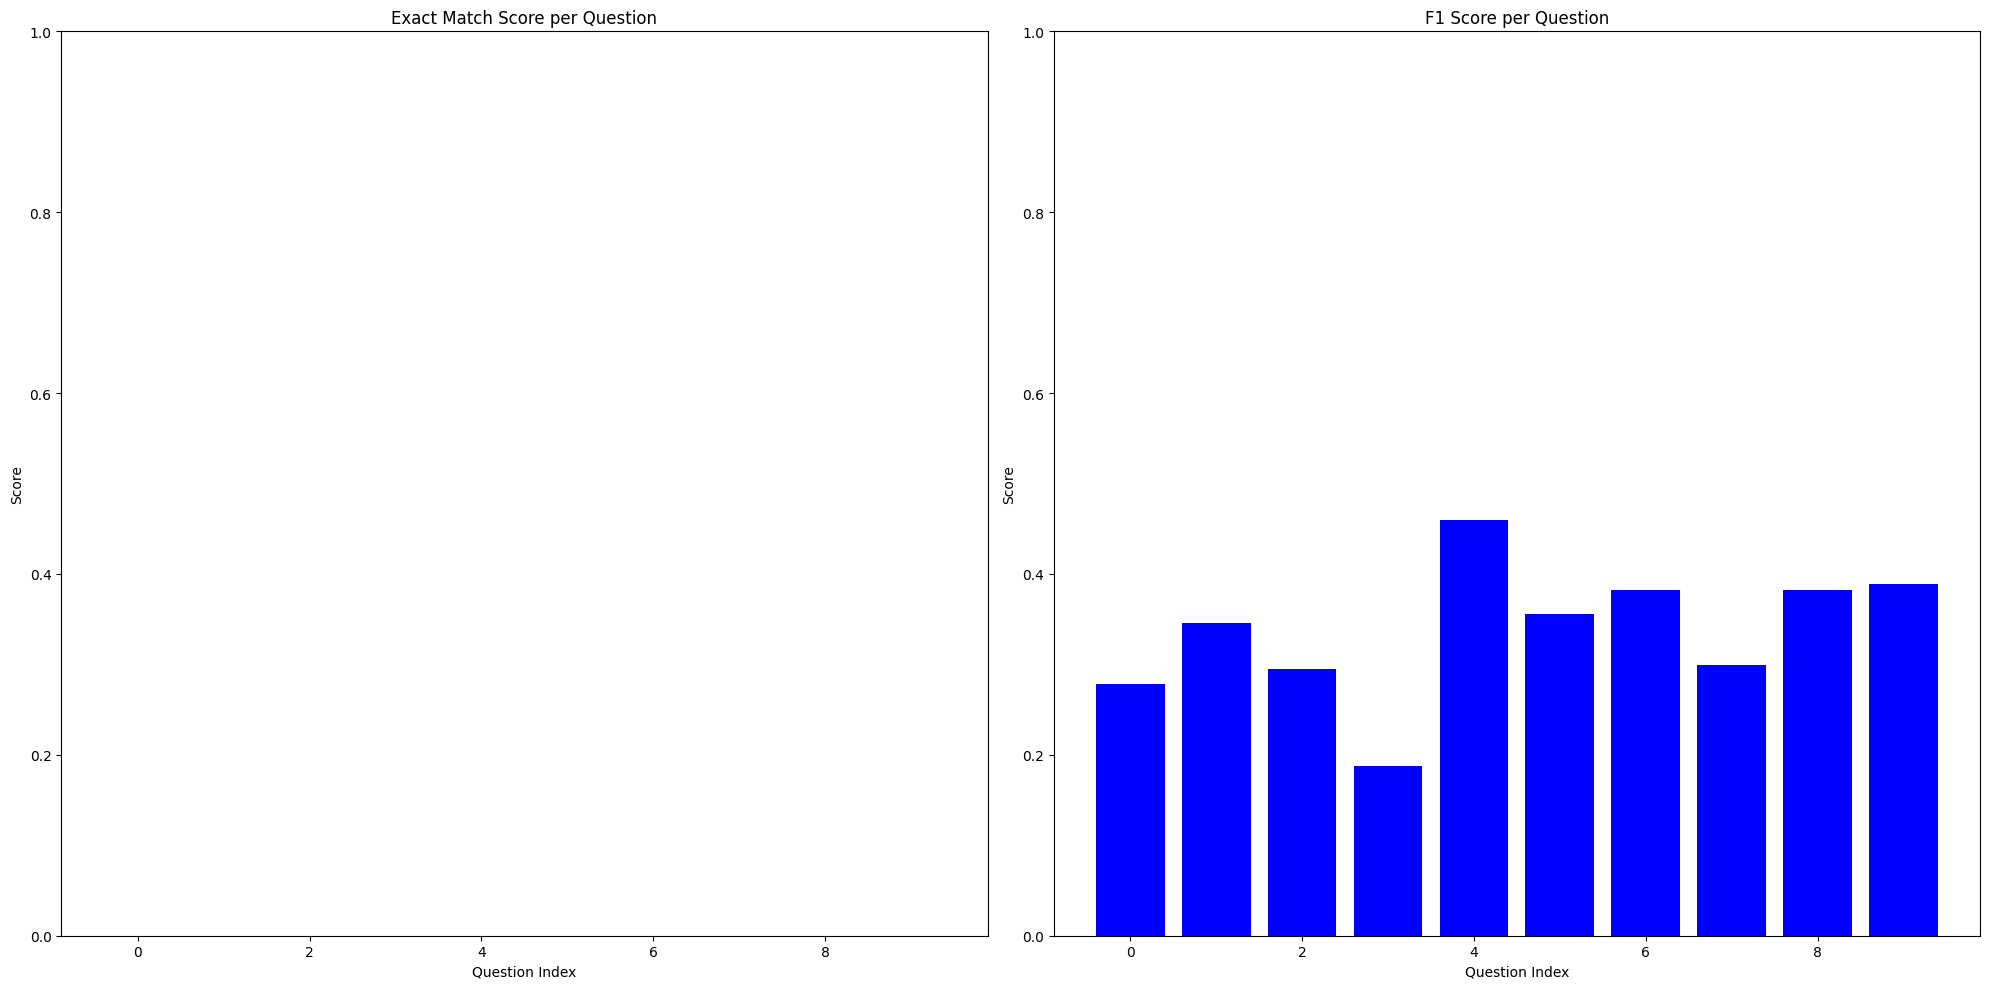

In [ ]:
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.prompts import PromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.llms import CTransformers, LlamaCpp
from langchain.chains import RetrievalQA
import matplotlib.pyplot as plt
from collections import Counter

# Define the database path for FAISS
DB_FAISS_PATH = '/content/vectorstore/db_faiss'

# Define a custom prompt template
custom_prompt_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful answer:
"""

def set_custom_prompt():
    """ Prompt template for QA retrieval for each vectorstore """
    prompt = PromptTemplate(template=custom_prompt_template, input_variables=['context', 'question'])
    return prompt

def retrieval_qa_chain(llm, prompt, db):
    qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                       chain_type='stuff',
                                       retriever=db.as_retriever(search_kwargs={'k': 2}),
                                       return_source_documents=True,
                                       chain_type_kwargs={'prompt': prompt}
                                       )
    return qa_chain

def load_llm():
    """ Load the locally downloaded model """
    llm = LlamaCpp(
        streaming=True,
        model_path="/content/drive/MyDrive/llama-2-7b-chat.Q4_K_M.gguf",
        model_type="llama",
        top_p=1,
        max_new_tokens=512,
        temperature=0.3
    )
    return llm

def qa_bot():
    """ Initialize and return the QA bot """
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                       model_kwargs={'device': 'cpu'})
    db = FAISS.load_local(DB_FAISS_PATH, embeddings, allow_dangerous_deserialization= True)
    llm = load_llm()
    qa_prompt = set_custom_prompt()
    qa = retrieval_qa_chain(llm, qa_prompt, db)
    return qa

def final_result(query):
    qa_result = qa_bot()
    response = qa_result({'query': query})
    answer = response['result']
    return answer



def exact_match_score(prediction, ground_truth):
    return prediction.strip().lower() == ground_truth.strip().lower()

def f1_score(prediction, ground_truth):
    prediction_tokens = prediction.strip().lower().split()
    ground_truth_tokens = ground_truth.strip().lower().split()
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_common = sum(common_tokens.values())
    if num_common == 0:
        return 0
    precision = num_common / len(prediction_tokens)
    recall = num_common / len(ground_truth_tokens)
    return 2 * (precision * recall) / (precision + recall)

def evaluate_model_detailed(model_func, dataset):
    detailed_scores = []
    for item in dataset:
        question = item['question']
        ground_truth_answer = item['answer']
        predicted_answer = model_func(question)

        em = exact_match_score(predicted_answer, ground_truth_answer)
        f1 = f1_score(predicted_answer, ground_truth_answer)

        detailed_scores.append({'question': question, 'EM': em, 'F1': f1})

    return detailed_scores

def plot_scores(detailed_scores):
    """ Plot the detailed scores for Exact Match and F1 """
    em_scores = [item['EM'] for item in detailed_scores]
    f1_scores = [item['F1'] for item in detailed_scores]
    questions = range(len(detailed_scores))

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].bar(questions, em_scores, color='skyblue')
    ax[0].set_title('Exact Match Score per Question')
    ax[0].set_xlabel('Question Index')
    ax[0].set_ylabel('Score')
    ax[0].set_ylim(0, 1)

    ax[1].bar(questions, f1_scores, color='blue')
    ax[1].set_title('F1 Score per Question')
    ax[1].set_xlabel('Question Index')
    ax[1].set_ylabel('Score')
    ax[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    pre_finetuned_model = load_llm()
    dataset = [
    {"question": "How does Python's interpretation of non-zero numbers as ""true"" affect conditional statements? Can you provide an example where this might be confusing?",  "answer": "Python interprets any non-zero number as ""true"" for logical operations. This can be helpful in some situations, but it can also be confusing because it can lead to unexpected results if we are not careful. For example, suppose we have a program that checks if a number is positive: if x > 0: print(""x is positive"") if x < 0: print(""x is negative"") if x == 0: print(""x is zero"") In this code, we have three if statements checking different conditions. However, if x is -10, then x is not greater than zero, but it is not less than zero either. Since x is a non-zero number, it is interpreted as ""true"" for logical operations. Therefore, the program will output: x is positive x is negative This output is unexpected and may be confusing for the user. To avoid this confusion, we should be careful when using logical operations with non-zero numbers and make sure our conditions are clear and unambiguous"},
    {"question":"Explain the differences between syntax errors, logic errors, and semantic errors in Python programming and provide examples for each type" , "answer": "Syntax errors are mistakes in the use of the Python language syntax, such as missing colons, incorrect indentation, or misuse of keywords. For example, 'for i in range(5)' without a colon at the end. Logic errors occur when a program runs without crashing but produces incorrect results, such as calculating the average of numbers incorrectly due to an error in the summing logic. Semantic errors are related to the meaning of the program; the syntax and logic could be correct, but the program does not do what the programmer intended. An example could be using a variable name incorrectly, leading to unexpected program behavior."},
    {"question": "What is the purpose of function calls?", "answer": "A function is a named sequence of statements that performs a computation when called. When we define a function, we specify its name and sequence of statements. Later, we can call it by name with an argument or arguments. The argument or arguments are values or variables we pass into the function as input to the function. The result is called the return value or values. The purpose of function calls is to execute a predefined sequence of statements when called."},
    {"question": "What happens if we use commas between groups of digits while typing a large integer?","answer": "Python interprets this as a comma-separated sequence of integers."},
    {"question": "What is a built-in function and how can it be used without defining it?", "answer": "A built-in function is a pre-defined function provided by Python's creators that can be used without defining it. To use a built-in function, simply call it with appropriate arguments inside parentheses and assign its return value to a variable or print it directly. For example: `result = max(values)` or `print(len(string))`. These functions do not require a function deﬁnition to be created beforehand, as their functionality is already provided by Python."},
    {"question": "Why does short-circuit evaluation lead to a clever technique like the guardian pattern?", "answer": "The short-circuit behavior of logical expressions allows us to use a technique called the guardian pattern. In this pattern, we use a logical expression that evaluates a condition and then another logical expression inside an ""and"" or ""or"" operator. By using this pattern, we can ensure that some operations are skipped if their conditions are False. This can save us time and improve performance by avoiding unnecessary computations. In the previous example, we used the guardian pattern to avoid a potential runtime error when evaluating a complex logical expression involving division by zero. By including a guardian expression (y != 0) in the logical "},
    {"question": "What is the result or return value of a function?" , "answer": "The result or return value of a function is the value or expression that is computed and returned when the function is executed or called. When a function is called, it performs some computation on its arguments and returns a result. The result is assigned to a variable or displayed directly using print. The result is also sometimes called the output or output value of the function."},
    {"question": "What does the float() function do? How does it convert integers and strings to floating-point numbers?", "answer": "The float() function in Python converts its argument to a floating-point number. When converting integers to floating-point numbers, there is no rounding off involved; instead, the fraction part is simply chopped off. When converting strings, if the string can be parsed as a valid number (i.e., a valid combination of digits and decimal points), then float() converts it to a floating-point number; otherwise, it raises a ValueError exception."},
    {"question": "What are operators? What are their operands? How can we perform division in Python?" , "answer": "Operators are symbols that perform operations on operands (values or variables). Python supports various operators for arithmetic like +, -, *, /, and others. Division is performed using the / operator, resulting in a float."},
    {"question": "What happens when a function is called within another function?" , "answer": "When a function is called within another function, it is known as a nested function call or a function call within a function. This means that a function is called as part of another function's execution. The inner function may access any variables defined in the outer function as well as any variables defined in the global scope or other modules. The inner function has its own local scope where it can store variables distinct from those in the outer function's scope. The execution of the inner function will pause when it is called and will only continue when the calling function returns its result or when a return statement is executed within the inner function. This mechanism allows for complex and hierarchical program structures."},

]
    detailed_scores = evaluate_model_detailed(final_result, dataset)
    plot_scores(detailed_scores)


